In [45]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
import os

%matplotlib inline

NUM_ITER = 10000

In [46]:
df = pd.read_csv("1976-2020-president.csv") # Read in the election results in each state going back to 1976.

In [47]:
STARTYEAR = 0 #YEAR WHEN WE START INTERPRETING THE DATA
ELECTIONYEAR = 2024 # YEAR WE WANT TO PREDICT
df = df[(STARTYEAR <= df['year']) & (df['year']<ELECTIONYEAR)] # SLICE THE DATA FOR ABOVE


In [48]:
df['party_simplified'] = df['party_simplified'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else '3RDPARTY') # COMPRESS ALL THIRD PARTIES INTO ONE VALUE

df_grouped = df.groupby(['year', 'state_po', 'party_simplified'], as_index=False).agg({'candidatevotes': 'sum'}) # 

state_votes = df_grouped.pivot_table(index='state_po', columns=['party_simplified','year'], values='candidatevotes', fill_value=0) # GET THE STATE VOTES BY PARTY BY YEAR


In [49]:
total_votes = state_votes.sum().groupby(level='year').sum()
total_share = state_votes.sum() / state_votes.sum().index.get_level_values('year').map(total_votes) # CONVERT TO VOTESHARE

In [50]:
def predict(t,X,weights=None): # LINEAR REGRESSION MODEL
    model = LinearRegression()
    model.fit(t.reshape(-1, 1), X, sample_weight=weights)
    m = model.coef_[0]
    b = model.intercept_

    Xhats = m*t + b
    Xpred = m*ELECTIONYEAR + b
    Xvar = np.sum((X-Xhats)**2) / (len(X) - 2) * 1.75

    return Xpred, Xhats, Xvar

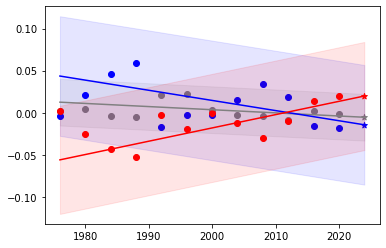

In [51]:
prior_diffs = {}
for i,the_state_vote in state_votes.iterrows():
    state_share = the_state_vote / the_state_vote.index.get_level_values('year').map(the_state_vote.groupby(level='year').sum()) # Convert the raw votes to percentages of the total vote in that state
    state_diff = state_share - total_share # Get the shift compared to the national share of the vote

    t = the_state_vote["DEMOCRAT"].index.values # Election years included in the model
    # tweights = np.arccos(1 - 2* ((t - t[0]) / (t - t[0])[-1])) /np.pi
    tweights = (t-t[0])**2

    other_diff_ = state_diff["3RDPARTY"].values
    other_diff_pred, other_diff_hats, other_diff_var = predict(t,other_diff_,tweights)
    other_diff_pred_ci = 1.96 * np.sqrt(other_diff_var)



    dem_diff_ = state_diff["DEMOCRAT"].values
    dem_diff_pred, dem_diff_hats, dem_diff_var = predict(t,dem_diff_,tweights)
    dem_diff_pred_ci = 1.96 * np.sqrt(dem_diff_var)

    rep_diff_ = state_diff["REPUBLICAN"].values
    rep_diff_pred, rep_diff_hats, rep_diff_var = predict(t,rep_diff_,tweights)
    rep_diff_pred_ci = 1.96 * np.sqrt(rep_diff_var)

    if i=="WI":
        fig,ax = plt.subplots()
        ax.scatter(t,other_diff_,color='grey')
        ax.plot(np.append(t,ELECTIONYEAR),np.append(other_diff_hats,other_diff_pred),color='grey')
        ax.scatter(ELECTIONYEAR,other_diff_pred,color='grey',marker='*')
        ax.fill_between(np.append(t,ELECTIONYEAR), (np.append(other_diff_hats,other_diff_pred)-other_diff_pred_ci), (np.append(other_diff_hats,other_diff_pred)+other_diff_pred_ci), color='grey', alpha=.1)

        ax.scatter(t,dem_diff_,color='blue')
        ax.plot(np.append(t,ELECTIONYEAR),np.append(dem_diff_hats,dem_diff_pred),color='blue')
        ax.scatter(ELECTIONYEAR,dem_diff_pred,color='blue',marker='*')
        ax.fill_between(np.append(t,ELECTIONYEAR), (np.append(dem_diff_hats,dem_diff_pred)-dem_diff_pred_ci), (np.append(dem_diff_hats,dem_diff_pred)+dem_diff_pred_ci), color='blue', alpha=.1)

        ax.scatter(t,rep_diff_,color='red')
        ax.plot(np.append(t,ELECTIONYEAR),np.append(rep_diff_hats,rep_diff_pred),color='red')
        ax.scatter(ELECTIONYEAR,rep_diff_pred,color='red',marker='*')
        ax.fill_between(np.append(t,ELECTIONYEAR), (np.append(rep_diff_hats,rep_diff_pred)-rep_diff_pred_ci), (np.append(rep_diff_hats,rep_diff_pred)+rep_diff_pred_ci), color='red', alpha=.1)

    prior_diffs[the_state_vote.name] = {
        "other_diff":other_diff_pred,
        "other_var":other_diff_var,
        "dem_diff" :dem_diff_pred,
        "dem_var": dem_diff_var,
        "rep_diff": rep_diff_pred,
        "rep_var":rep_diff_var,    }
prior_diffs = pd.DataFrame(data=prior_diffs).T

In [52]:
national_vals = pd.read_csv("polling_averages/National.csv",index_col='date')
todays_nat_polls = national_vals.loc[dt.today().strftime('%Y-%m-%d')]
state_mapper = pd.read_csv("state_mapper.csv",index_col='state').to_dict()['code']

poll_other = 1 - todays_nat_polls["harris_mean"] - todays_nat_polls["trump_mean"]
poll_dem = todays_nat_polls["harris_mean"]
poll_rep = todays_nat_polls["trump_mean"]

post_preds = prior_diffs[['other_diff','dem_diff','rep_diff']].copy()
post_preds['other_diff'] += poll_other
post_preds['dem_diff'] += poll_dem
post_preds['rep_diff'] += poll_rep
post_preds.rename({'other_diff':'other_vote','dem_diff':'dem_vote','rep_diff':'rep_vote'},axis=1,inplace=True)


post_vars = prior_diffs[['other_var','dem_var','rep_var']].copy()
post_vars['dem_var'] = post_vars['dem_var'] + todays_nat_polls["harris_var"]
post_vars['rep_var'] = post_vars['rep_var'] + todays_nat_polls["trump_var"]


for state_avgs in os.listdir("polling_averages"):
    if state_avgs[:-4] in state_mapper.keys():
        state_avgs_polls = pd.read_csv(f"polling_averages/{state_avgs}",index_col='date')

        todays_state_polls = state_avgs_polls.loc[dt.today().strftime('%Y-%m-%d')] # 
        
        pre_poll_preds = post_preds.loc[state_mapper[state_avgs[:-4]]][["dem_vote","rep_vote"]].copy().values
        pre_poll_vars = post_vars.loc[state_mapper[state_avgs[:-4]]][["dem_var","rep_var"]].copy().values

        pollmeans = todays_state_polls[["harris_mean","trump_mean"]].values
        pollvars = todays_state_polls[["harris_var","trump_var"]].values

        post_poll_preds = (pre_poll_preds/pre_poll_vars + pollmeans/pollvars) / (1/pre_poll_vars + 1/pollvars)
        post_poll_vars = 1 / (1/pre_poll_vars + 1/pollvars)

        post_preds.loc[state_mapper[state_avgs[:-4]],'dem_vote'] = post_poll_preds[0]
        post_preds.loc[state_mapper[state_avgs[:-4]],'rep_vote'] = post_poll_preds[1]
        post_preds.loc[state_mapper[state_avgs[:-4]],'other_vote'] = 1 - post_poll_preds[0] - post_poll_preds[1]

        post_vars.loc[state_mapper[state_avgs[:-4]],'dem_var'] = post_poll_vars[0]
        post_vars.loc[state_mapper[state_avgs[:-4]],'rep_var'] = post_poll_vars[1]


In [53]:
# Assume 0.5% random walk each day. Move the variance depending on the number of days remaining.
post_vars = post_vars + post_preds.values*(dt.strptime("2024-11-05",'%Y-%m-%d') - dt.today()).days * 0.005**2 

In [54]:
electoralvotes = {
    "AL":9,
    "AK":3,
    "AZ":11,
    "AR":6,
    "CA":54,
    "CO":10,
    "CT":7,
    "DC":3,
    "DE":3,
    "FL":30,
    "GA":16,
    "HI":4,
    "ID":4,
    "IL":19,
    "IN":11,
    "IA":6,
    "KS":6,
    "KY":8,
    "LA":8,
    "ME":4,
    "MD":10,
    "MA":11,
    "MI":15,
    "MN":10,
    "MS":6,
    "MO":10,
    "MT":4,
    "NE":5,
    "NV":6,
    "NH":4,
    "NJ":14,
    "NM":5,
    "NY":28,
    "NC":16,
    "ND":3,
    "OH":17,
    "OK":7,
    "OR":8,
    "PA":19,
    "RI":4,
    "SC":9,
    "SD":3,
    "TN":11,
    "TX":40,
    "UT":6,
    "VT":3,
    "VA":13,
    "WA":12,
    "WV":4,
    "WI":10,
    "WY":3}	


In [55]:
def to_cov(row,column):
    return row * np.sqrt(column.loc[row.name]) * np.sqrt(column)

In [56]:
correlation_factor = 0.5 # How correlated do we expect the previous correlations to predict the next correlations. Defaults to 0.5
rep_cov = state_votes['REPUBLICAN'].T.corr()
rep_cov = np.eye(rep_cov.shape[0])*(1-correlation_factor) + rep_cov*correlation_factor
rep_cov = rep_cov.apply(lambda row: to_cov(row,post_vars['rep_var']))


dem_cov = state_votes['DEMOCRAT'].T.corr()
dem_cov = np.eye(dem_cov.shape[0])*(1-correlation_factor) + dem_cov*correlation_factor
dem_cov = dem_cov.apply(lambda row: to_cov(row,post_vars['dem_var']))

oth_cov = state_votes['3RDPARTY'].T.corr()
oth_cov = np.eye(oth_cov.shape[0])*(1-correlation_factor) + oth_cov*correlation_factor
oth_cov = oth_cov.apply(lambda row: to_cov(row,post_vars['other_var']))

In [57]:
outputs = [] # SIMULATE ALL THE ELECTION RESULTS
for _ in range(NUM_ITER):
    election = pd.DataFrame(data = [np.clip(np.random.multivariate_normal(post_preds["rep_vote"],rep_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds["dem_vote"],dem_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds["other_vote"],oth_cov),0,1)
                            ], columns=rep_cov.columns,index=["rep_share","dem_share","oth_share"]).T
    
    harris_popular_vote = np.average(election['dem_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    trump_popular_vote = np.average(election['rep_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    oth_popular_vote = np.average(election['oth_share'],weights=state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum())
    
    election['margin']=election["dem_share"] - election["rep_share"]
    election.sort_values(by='margin',ascending=False,inplace=True)

    election['winner']=["Harris"if res else "Trump" for res in election['margin']>0 ]

    election["Cummulative Trump EV"] = 0
    election["Cummulative Harris EV"] = 0



    harris_ev = 0
    trump_ev = 0
    other_ev = 0


    for state_name, result in election.iterrows():
        if result['winner']=="Harris":
            harris_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Harris EV"] = harris_ev

    election.sort_values(by='margin',ascending=True,inplace=True)
    for state_name, result in election.iterrows():
        if result['winner']=="Trump":
            trump_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Trump EV"] = trump_ev

    # Check if Electoral Vote Tie
    if (election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any().all():
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any(axis=1)]['margin'].abs().idxmin()
    else:
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]>= 270).any(axis=1)][["Cummulative Harris EV","Cummulative Trump EV"]].sum(axis=1).idxmin()
 


    output_df = election[["rep_share","dem_share","oth_share","winner"]]
    output = {
        "df":output_df,
        "facts":{
            "harris_popular_vote":harris_popular_vote,
            "trump_popular_vote":trump_popular_vote,
            "oth_popular_vote":oth_popular_vote,
            "tipping_point_state":tipping_point_state,
            "harris_ev":harris_ev
        }
    }
    outputs.append(output)

In [58]:
combined_df = pd.concat([output['df'] for output in outputs],axis=0)
median_df = combined_df[["rep_share",	"dem_share","oth_share"]].groupby(level=0).median()

In [59]:
def ensure_harris(counts):
    if "Harris" not in counts:
        counts["Harris"] = 0
    return counts
state_probs = combined_df.groupby(combined_df.index)["winner"].apply(lambda x: x.value_counts())
state_probs = state_probs.groupby(level=0).apply(ensure_harris)
state_probs = state_probs.reset_index(level=1, drop=True).unstack(fill_value=0).drop('',axis=1)

In [60]:
model_outputs = {}
for i,row in median_df.iterrows():
    p_dem_win = state_probs.loc[i,"Harris"] / state_probs.loc[i].sum()
    dem_margin_median = row["dem_share"] - row["rep_share"]


    model_outputs[i] = {
        "Probability Harris Win":p_dem_win,
        "Median Harris Margin":dem_margin_median,
        "Harris Voteshare":row["dem_share"],
        "Trump Voteshare":row["rep_share"],
        "Other Voteshare":row["oth_share"],
        "Total Number of Votes":state_votes.T.loc[(slice(None), ELECTIONYEAR-4), :].droplevel('year').sum()[i],
        "EV":electoralvotes[i]
    }
model_outputs = pd.DataFrame(data = model_outputs).T

In [227]:
text = model_outputs.apply(lambda row:
                           f" <b><i>{df[['state','state_po']].set_index('state_po').to_dict()['state'][row.name]}</i> {int(row['EV'])} EV's</b> \
                           <br><i>Probability Harris Wins</i>: <b>{np.round(row['Probability Harris Win']*100,1)}%</b> \
                           <br><i>Predicted Harris Voteshare</i>: <b>{np.round(row['Harris Voteshare']*100,1)}%</b> \
                            <br><i>Predicted Trump Voteshare</i>: <b>{np.round(row['Trump Voteshare']*100,1)}%</b> \
                           <br><i>Predicted Other Voteshare</i>: <b>{np.round(row['Other Voteshare']*100,1)}%</b> \
                            ",axis=1)

In [228]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
chloropleth_cmap = [(0, republican_red),(0.5,"white"), (1, democratic_blue)]
histogram_cmap = [(0, republican_red),(0.4, republican_red), (0.5,"#c478b1"), (0.6, democratic_blue), (1, democratic_blue)]

In [229]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=model_outputs.index, # Spatial coordinates
    z = model_outputs["Probability Harris Win"], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = chloropleth_cmap,
    # colorbar_title = "Probability Harris Win",
    text = text,
    hoverinfo="text",
    showscale=False
))

fig.update_layout(
    # title_text = f'2024 Electoral Forecast: Kamala Harris has a {OVERALL["Probability Harris Win"].round(3)*100}% chance to win the election',
    dragmode=False,
    geo_scope='usa', # limite map scope to USA
    title=None,  # Remove title
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space
)
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=model_outputs.index, # Spatial coordinates

#     text=[f'<a href="https://plot.ly/"> </a>' for state in model_outputs.index],
#     mode='text',
#     textposition='middle center',
#     showlegend=False,
#     hoverinfo='none'
# ))
fig.write_html("docs/chloropleth.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [230]:
run = [2*output['facts']['harris_ev']-538 for output in outputs]

In [231]:
min(run)

-262

In [232]:
# counts,bins = np.histogram(run,bins=85,range=(2*100-538,2*440-538))
counts,bins = np.histogram(run,bins=max(np.abs(min(run)),np.abs(max(run))),range=(-max(np.abs(min(run)),np.abs(max(run))),max(np.abs(min(run)),np.abs(max(run)))))

# counts,bins = np.histogram(run,bins=340,range=(100,440))

In [233]:
text = [f"<b>Harris wins {(int(bins[i])+538)//2} EV's and Trump wins {(-int(bins[i])+538)//2} EV's<br> in {np.round(count/sum(counts)*100,1)}% of {sum(counts)} simulations </b>" for i,count in enumerate(counts)]

In [234]:
fig = go.Figure(data=[go.Bar(
    x=bins,
    y=counts/sum(counts)*100,
    marker={'color': bins, 'colorscale': histogram_cmap},
    text =text,    
    hoverinfo='text',
    textposition = "none"
    )])
# Add titles and labels
fig.update_layout(
    # title='Histogram of Electoral Votes',
    xaxis_title='Harris Electoral College Vote',
    yaxis_title='Probability %',
)
fig.add_shape(
    go.layout.Shape(
        type='line',
        x0=0,
        y0=0,
        x1=0,
        y1=max(fig.data[0].y)*1.05,  # Adjust y1 to match the range of your data
        line=dict(
            color='Black',
            width=2,
            dash='dot',  # Dotted line
        ),
    )
)
fig.add_annotation(
    x=0,
    y=max(fig.data[0].y),  # Position text slightly below the top of the y-axis
    text="<b>Harris wins the election<b><br>---------->",
    showarrow=True,
    arrowhead=0,
    ax=85,  # X offset for the text
    ay=0,   # Y offset for the text
    font=dict(size=12, color="Black"),
    align='left'
)
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(range=[-max(np.abs(min(run)),np.abs(max(run))), max(np.abs(min(run)),np.abs(max(run)))],
            tickvals=[300, 200, 100, 0, -100, -200, -300],  # Custom tick values
            ticktext=["D +300", "D +200", "D +100","0", "R +100","R +200","R +300"]),  # Set the width of the x-axis line

    dragmode=False,

    hovermode="x",
    margin=dict(l=0, r=0, t=0, b=0)  # Constrain layout with tighter margins
)

# fig.show()
fig.write_html("docs/histogram.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [235]:
pwin = sum([output['facts']['harris_ev']>=270 for output in outputs])/NUM_ITER
median_ev = np.median([output['facts']['harris_ev'] for output in outputs])

In [236]:
(pd.Series([output['facts']['harris_popular_vote']-output['facts']['trump_popular_vote'] for output in outputs])>0).value_counts()

True     7770
False    2230
dtype: int64

In [237]:
text = []

for output in outputs:
    if output['facts']['harris_ev']>270:
        text.append(f"<b>Harris wins with {output['facts']['harris_ev']} EV's. \
                    <br>Harris wins {np.round(output['facts']['harris_popular_vote']*100,1)}% of the vote to \
                    <br>Trump's {np.round(output['facts']['trump_popular_vote']*100,1)}%")
    elif output['facts']['harris_ev']<269:
        text.append(f"<b>Trump wins with {538 - output['facts']['harris_ev']} EV's. \
            <br>Trump wins {np.round(output['facts']['trump_popular_vote']*100,1)}% of the vote to \
            <br>Harris's {np.round(output['facts']['harris_popular_vote']*100,1)}%")
    else:
        text.append(f"<b>269 - 269: Electoral college tie. \
            <br>Trump wins {np.round(output['facts']['trump_popular_vote']*100,1)}% of the vote to \
            <br>Harris's {np.round(output['facts']['harris_popular_vote']*100,1)}%")

In [244]:
vote_margin = np.array([output['facts']['trump_popular_vote']-output['facts']['harris_popular_vote'] for output in outputs])[:1000]
ev_margin = np.array([2*output['facts']['harris_ev']-538 for output in outputs])[:1000]
color = np.where(ev_margin == 0, 'gray', np.where(ev_margin > 0, democratic_blue, republican_red))
alpha = np.where(
    ((ev_margin > 0) & (vote_margin > 0)) | ((ev_margin < 0) & (vote_margin < 0)), 0.4, 1.0
)

# Create scatter plot
fig = go.Figure(data=go.Scatter(
    y=vote_margin,
    x=ev_margin,
    mode='markers',
    marker=dict(
        color=color,  # Color based on the condition
        opacity=alpha,  # Opacity based on the condition
        size=8,  # Marker size (adjust as needed)
        line=dict(width=1, color='white')  # Add white border to markers
    ),
    text =text,    
    hoverinfo='text',
    # textposition = "none"
))

# Customize layout
fig.update_layout(
    yaxis=dict(range=[-0.2, 0.2],
        tickvals=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15],  # Custom tick values
        ticktext=["D +15", "D +10", "D +5","0", "R +5","R +10","R +15"],  # Custom tick labels
        showgrid=False,
        zeroline=True,  # Add a line at y=0 (major x-axis)
        zerolinecolor='black',  # Set the color of the x-axis line
        zerolinewidth=2  # Set the width of the x-axis line
    ),    
    
    xaxis=dict(range=[-max(np.abs(min(run)),np.abs(max(run))), max(np.abs(min(run)),np.abs(max(run)))],
        tickvals=[300, 200, 100, 0, -100, -200, -300],  # Custom tick values
        ticktext=["D +300", "D +200", "D +100","0", "R +100","R +200","R +300"],  # Custom tick labels
        showgrid=False,
        zeroline=True,  # Add a line at y=0 (major x-axis)
        zerolinecolor='black',  # Set the color of the x-axis line
        zerolinewidth=2  # Set the width of the x-axis line
    ),        
    # width=500,  # Width of the plot
    # height=500,  # Height of the plot (same as width to make it square)
    plot_bgcolor="rgba(0, 0, 0, 0)",  # Set the background color to white
    margin=dict(l=0, r=0, t=0, b=0),  # Constrain layout with tighter margins
    dragmode=False,

)

# Show the plot
fig.write_html("docs/ev_vote2.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [239]:
pwin

0.5863

In [240]:
median_ev

282.0

In [241]:
np.median([output['facts']['harris_popular_vote'] for output in outputs]) - np.median([output['facts']['trump_popular_vote'] for output in outputs])

0.029716012559472316

In [242]:
tipping_points = pd.Series([output['facts']['tipping_point_state'] for output in outputs])
tipping_points.value_counts()/tipping_points.value_counts().sum()

PA    0.1842
NC    0.1269
MI    0.1006
FL    0.0931
AZ    0.0727
WI    0.0722
TX    0.0718
GA    0.0687
MN    0.0668
VA    0.0528
NV    0.0384
NH    0.0131
IA    0.0094
OH    0.0070
SC    0.0064
CO    0.0045
AK    0.0031
RI    0.0016
NM    0.0015
NJ    0.0012
ME    0.0011
IL    0.0010
OR    0.0007
CT    0.0005
MS    0.0003
KS    0.0002
DE    0.0001
NY    0.0001
dtype: float64

In [243]:
for i in range(10):# Create the choropleth map
    fig = go.Figure(data=go.Choropleth(
        locations=outputs[i]['df'].index,  # State codes
        z=outputs[i]['df']['winner'].map({'Harris': 1, 'Trump': 0}),  # Numeric mapping of candidates
        locationmode='USA-states',  # Specify that locations are state codes
        colorscale=[[0, republican_red], [1, democratic_blue]],  # Define color scale (0 = Trump, 1 = Harris)
        showscale=False,  # Disable the color scale bar
        text=outputs[i]['df']['winner'],  # Hover text showing the candidate
    ))

    # Update layout for a better appearance
    fig.update_layout(
        # title_text="2024 Election Map",
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # Show lakes
            lakecolor='rgb(255, 255, 255)',
            bgcolor='rgba(0,0,0,0)',  # Set background to transparent
        ),
        margin=dict(l=0, r=0, t=0, b=0)  # Constrain layout with tighter margins
    )

    fig.write_html(f"docs/assets/example_chloros/chloropleth_example_{i}.html",config={'staticPlot': True})